In [1]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt
import pickle
import time

import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

Welcome to JupyROOT 6.28/00


2023-04-26 22:44:18.570977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 22:44:19.940795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[]
Num GPUs Available:  0


2023-04-26 20:14:27.175627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"

files = os.listdir(dir_path)

DMesonsTTree = process_ntuple(dir_path, files[0])
LambdaMesonsTTree = process_ntuple(dir_path, files[1])

branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId", 
            "DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId",
           "DMesons_fitOutput__ImpactSignificance"]

to_add = ["DMesons_fitOutput__ImpactSignificance"]
print(files)

['CharmAnalysis.mc.ForcedDecay.Dplus.tree.root', 'CharmAnalysis.mc.ForcedDecay.LabmdaC.tree.root']


In [8]:
DMesons_df = generate_df(DMesonsTTree, branches, 2000000)
DMesons_df = apply_cuts(DMesons_df)

pd.set_option('display.max_rows', 10)
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance
0,[10.047125],[0.08182407170534134],[1862.4176025390625],[2.3395302295684814],[0.25487038493156433],[411],"[[6.094892978668213, 1.3074619770050049, 2.733...","[(0.15998553, 0.011107716, -0.0614343)]","[(2.6128821, 2.7195172, 2.9228168)]","[(-321, 211, 211)]",[0.5543845891952515]
1,"[18.9937421875, 18.9937421875]","[-1.6619627475738525, -1.6619627475738525]","[1853.90625, 2398.886962890625]","[1.9184143543243408, 1.9184143543243408]","[-0.36730244755744934, -0.0650731548666954]","[411, 4122]","[[6.457057952880859, 5.970093250274658, 6.6375...","[(-1.608788, -1.6307458, -1.7315177), (-1.7326...","[(-0.371787, -0.5164238, -0.4971406), (-0.4966...","[(-321, 211, 211), (2212, -321, 211)]","[1.8095015287399292, 1.8095015287399292]"
2,"[10.118494140625, 10.118494140625]","[0.041659336537122726, 0.041659336537122726]","[1874.203125, 2468.1806640625]","[2.8901257514953613, 2.8901257514953613]","[0.06833142042160034, 0.4276972711086273]","[411, 4122]","[[3.7944977283477783, 3.3083105087280273, 3.06...","[(-0.073717244, 0.22605924, -0.017923404), (0....","[(0.753864, 0.6827104, 0.920779), (0.6827104, ...","[(-321, 211, 211), (2212, -321, 211)]","[2.292919158935547, 2.292919158935547]"
3,"[12.579470703125, 12.579470703125]","[-1.1025604009628296, -1.1025604009628296]","[1884.987060546875, 2220.384521484375]","[0.9249186515808105, 0.9249186515808105]","[-0.5603189468383789, -0.41332852840423584]","[411, 4122]","[[3.7815563678741455, 7.396467208862305, 1.412...","[(-0.9284433, -1.182188, -1.1012387), (-1.1821...","[(0.8518817, 0.7419038, 0.77916163), (0.741903...","[(-321, 211, 211), (2212, -321, 211)]","[0.7992758750915527, 0.7992758750915527]"
4,[36.1288359375],[0.6598162055015564],[2235.69873046875],[0.3584118187427521],[0.19036155939102173],[4122],"[[18.936317443847656, 15.39889907836914, 1.803...","[(0.69086045, 0.62282157, 0.63955635)]","[(0.857847, 0.81737196, 0.7582323)]","[(2212, -321, 211)]",[1.1388494968414307]
...,...,...,...,...,...,...,...,...,...,...,...
823353,[19.1050703125],[1.6708742380142212],[1802.5220947265625],[0.5411524176597595],[0.5503742098808289],[411],"[[12.198583602905273, 2.20495867729187, 4.7119...","[(1.705293, 1.5110217, 1.6457342)]","[(2.8939261, 2.7120652, 2.8616462)]","[(-321, 211, 211)]",[2.8667211532592773]
823354,"[35.5684921875, 35.5684921875]","[-1.688397765159607, -1.688397765159607]","[1844.779541015625, 2206.408203125]","[13.070379257202148, 13.070379257202148]","[-0.9140324592590332, -0.8278874754905701]","[411, 4122]","[[5.796909809112549, 20.56328582763672, 9.2475...","[(-1.6683935, -1.7061399, -1.6597538), (-1.706...","[(1.4682562, 1.4755678, 1.4053382), (1.4755678...","[(-321, 211, 211), (2212, -321, 211)]","[3.2546143531799316, 3.2546143531799316]"
823355,"[8.96414453125, 8.96414453125]","[-2.151238203048706, -2.151238203048706]","[1906.624267578125, 2233.773193359375]","[1.6992524862289429, 1.6992524862289429]","[0.1967991143465042, 0.495256245136261]","[411, 4122]","[[3.0222578048706055, 5.220008850097656, 0.736...","[(-2.0755956, -2.2418754, -1.6611706), (-2.241...","[(1.9180546, 1.8532572, 2.0587387), (1.8532572...","[(-321, 211, 211), (2212, -321, 211)]","[0.9604215025901794, 0.9604215025901794]"
823356,[17.66424609375],[-0.09207434207201004],[1886.3043212890625],[1.2944053411483765],[0.28153401613235474],[411],"[[9.11902904510498, 5.195584774017334, 3.37626...","[(-0.045325126, -0.065605104, -0.25413564)]","[(1.7839004, 1.9068127, 1.8262501)]","[(-321, 211, 211)]",[3.164067029953003]


In [9]:
Lambda_df = generate_df(LambdaMesonsTTree, branches, 2000000)
Lambda_df = apply_cuts(Lambda_df)

pd.set_option('display.max_rows', 10)
Lambda_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance
0,"[15.8373623046875, 15.8373623046875]","[-1.9853405952453613, -1.9853405952453613]","[2277.830078125, 2369.549072265625]","[0.04267885163426399, 0.04267885163426399]","[-0.2451278269290924, -0.17632918059825897]","[4122, 4122]","[[6.491756916046143, 3.2679483890533447, 6.113...","[(-2.0230656, -2.0707278, -1.8890115), (-1.889...","[(-2.1058285, -2.2039685, -2.201573), (-2.2013...","[(2212, -321, 211), (2212, -321, 211)]","[2.5830554962158203, 2.5830554962158203]"
1,"[98.7876796875, 98.7876796875]","[-0.2930956184864044, -0.2930956184864044]","[1919.40869140625, 2260.435791015625]","[2.1269333362579346, 2.1269333362579346]","[0.06200433894991875, 0.3847692906856537]","[411, 4122]","[[29.078584671020508, 10.136245727539062, 59.8...","[(-0.28745878, -0.29004973, -0.29698882), (-0....","[(-2.6987991, -2.6463094, -2.698718), (-2.6987...","[(-321, 211, 211), (2212, -321, 211)]","[1.1140474081039429, 1.1140474081039429]"
2,[8.6058642578125],[0.07536902278661728],[2293.048583984375],[0.09962315112352371],[0.4434269666671753],[4122],"[[2.7384893894195557, 4.709741592407227, 1.240...","[(0.19276412, 0.01101852, 0.053698417)]","[(-2.1192122, -1.8384731, -2.1108038)]","[(2212, -321, 211)]",[4.643901348114014]
3,[11.53853515625],[0.2006414383649826],[2288.4326171875],[0.48169323801994324],[0.9700170755386353],[4122],"[[2.246781587600708, 7.883712291717529, 1.4038...","[(0.20760234, 0.22167633, 0.07100553)]","[(-2.8044589, -2.8241496, -2.8006365)]","[(2212, -321, 211)]",[2.421121120452881]
4,[29.4526484375],[0.05501718819141388],[2301.531494140625],[1.2502720355987549],[0.7273651361465454],[4122],"[[8.355555534362793, 18.87540626525879, 2.2310...","[(0.10226753, 0.028720934, 0.09831465)]","[(1.4927285, 1.5366541, 1.5769836)]","[(2212, -321, 211)]",[2.595268964767456]
...,...,...,...,...,...,...,...,...,...,...,...
712648,"[34.463046875, 34.463046875]","[0.31471043825149536, 0.31471043825149536]","[1740.138671875, 2299.086181640625]","[1.5627269744873047, 1.5627269744873047]","[0.1562846302986145, 0.4890439212322235]","[411, 4122]","[[15.651188850402832, 5.544079780578613, 13.24...","[(0.3235349, 0.37399396, 0.2787361), (0.278787...","[(0.4758191, 0.5486185, 0.5259811), (0.5257968...","[(-321, 211, 211), (2212, -321, 211)]","[1.347546935081482, 1.347546935081482]"
712649,[21.214580078125],[-1.1575630903244019],[2294.565673828125],[0.4024292826652527],[-0.8603967428207397],[4122],"[[14.745858192443848, 2.744957447052002, 3.758...","[(-1.1659735, -1.0675877, -1.1798809)]","[(2.3274233, 2.2858722, 2.182565)]","[(2212, -321, 211)]",[4.43757963180542]
712650,[78.9265390625],[0.9490858316421509],[2278.0],[3.1103579998016357],[-0.23155681788921356],[4122],"[[22.820960998535156, 17.21006965637207, 38.08...","[(0.95355487, 0.96059924, 0.9411635)]","[(0.8717007, 0.89668804, 0.8914601)]","[(2212, -321, 211)]",[3.1761653423309326]
712651,"[8.3078798828125, 8.3078798828125]","[1.7236647605895996, 1.7236647605895996]","[2279.513427734375, 2440.34130859375]","[0.27863630652427673, 0.27863630652427673]","[-0.4692881405353546, -0.40096166729927063]","[4122, 4122]","[[4.055630683898926, 1.4534549713134766, 2.834...","[(1.6344042, 2.0164008, 1.6586056), (1.6573379...","[(-1.7249979, -1.4534848, -1.7085202), (-1.708...","[(2212, -321, 211), (2212, -321, 211)]","[0.8141367435455322, 0.8141367435455322]"


In [10]:
DMesons_df = remove_duplicates(DMesons_df)
Lambda_df = remove_duplicates(Lambda_df)

Removed 81475 duplicate particles
Removed 34651 duplicate particles


In [11]:
save(DMesons_df, "DMesons_df")
save(Lambda_df, "Lambda_df")

In [51]:
DMesons_df = load("DMesons_df")
Lambda_df = load("Lambda_df")

In [52]:
DMesons_df = DMesons_df.head(500000)
Lambda_df = Lambda_df.head(500000)

In [53]:
#separates each particle of the event into it's own event in a new data frame (for training)
def separate(df):
    dfs = []
    for index, row in df.iterrows():

        #reco Ds
        pts = row['DMesons_pt']
        etas = row['DMesons_eta']
        ms = row['DMesons_m']
        lxys = row['DMesons_fitOutput__Lxy']
        costhetastars = row['DMesons_costhetastar']
        impacts = row['DMesons_costhetastar']
        pdgids = row["DMesons_pdgId"]

        #reco Ds Daughter info
        daughter_pts = row["DMesons_daughterInfo__pt"]
        daughter_etas = row["DMesons_daughterInfo__eta"]
        daughter_phis = row["DMesons_daughterInfo__phi"]
        daughter_pdgIds = row["DMesons_daughterInfo__pdgId"]

        d = {df.columns[0]: pts, df.columns[1]: etas, df.columns[2]: ms, df.columns[3]: lxys, 
             df.columns[4]: costhetastars, df.columns[5]: pdgids, 

             df.columns[6]: daughter_pts, df.columns[7]: daughter_etas, df.columns[8]: daughter_phis, 
             df.columns[9]: daughter_pdgIds, 
             
             df.columns[10]: impacts}
        
        df = pd.DataFrame(data=d)

        dfs.append(df)

    df = pd.concat(dfs)
    df = df.reset_index(drop = True)
    return df

In [54]:
DMesons_df = separate(DMesons_df)
Lambda_df = separate(Lambda_df)

In [4]:
# save(DMesons_df, "DMesons_df_separated")
# save(Lambda_df, "Lambda_df_separated")

# DMesons_df = load("DMesons_df_separated")
# Lambda_df = load("Lambda_df_separated")

In [59]:
DPlus = [-321, 211, 211]
LambdaC = [2212, -321, 211]

remove_lambda = []

count = 0
for index, row in DMesons_df.iterrows():
    if count == 50:
        break
    count+=1
    
    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    pdgids = row["DMesons_daughterInfo__pdgId"]
    
    #loop through until the first lambda encountered
    for i in range(len(pdgids) - 1):
        #if there are multiple lambda baryons
        if len(pdgids) > 2:
            #stop at the first lambda and keep the higher proton pt valued lambda
            if list(pdgids[i]) == LambdaC:
                l1_pt, l2_pt = pts[i][0], pts[i + 1][0]
                if (l1_pt > l2_pt):
                    #Lambda 1's proton has higher pt
                    remove_lambda.append((index, i + 1))
                elif (l1_pt < l2_pt):
                    #Lambda 2's proton has higher pt!
                    remove_lambda.append((index, i))
                else:
                    raise Exception("Error: Are the proton pt vaules equal?")

len(remove_lambda)

3

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

pd.set_option('display.max_rows', 10)

In [11]:
def count(df):
    D = 0
    Lambda = 0
    for pdgId in df["DMesons_pdgId"]:
        if pdgId == 411 or pdgId == 0:
            D+=1
        elif pdgId == 4122 or pdgId == 1:
            Lambda+=1
    return D, Lambda

count(DMesons_df)

(6280052, 6017574)

In [55]:
def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    # else:
    #     return "both"

DMesons_df['particle_type'] = DMesons_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = DMesons_df[DMesons_df['particle_type'] == 'only_411']
only_4122 = DMesons_df[DMesons_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

#new_df = DMesons_df[DMesons_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [56]:
save(only_4122, "DMesons_only_4122")

In [57]:
# create a new column 'particle_type' based on the pdgId column

def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    # else:
    #     return "both"

Lambda_df['particle_type'] = Lambda_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = Lambda_df[Lambda_df['particle_type'] == 'only_411']
only_4122 = Lambda_df[Lambda_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

# new_df = Lambda_df[Lambda_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [58]:
save(only_4122, "Lambda_only_4122")

In [59]:
# Read
Lambda_only_4122 = load("Lambda_only_4122")
DMesons_only_4122 = load("DMesons_only_4122")

In [61]:
DMesons_only_4122['DMesons_pdgId'] = DMesons_only_4122['DMesons_pdgId'].replace({4122: 411})

DMesons_only_4122

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance,particle_type
2,18.993742,-1.661963,2398.886963,1.918414,-0.065073,411,"[6.605627059936523, 6.457057952880859, 5.96782...","(-1.7326077, -1.608788, -1.6305238)","(-0.49662885, -0.371787, -0.5161313)","(2212, -321, 211)",-0.065073,only_4122
4,10.118494,0.041659,2468.180664,2.890126,0.427697,411,"[3.3083105087280273, 3.7944977283477783, 3.065...","(0.22605924, -0.073717244, -0.017923404)","(0.6827104, 0.753864, 0.920779)","(2212, -321, 211)",0.427697,only_4122
6,12.579471,-1.102560,2220.384521,0.924919,-0.413329,411,"[7.396467208862305, 3.7815563678741455, 1.4123...","(-1.182188, -0.9284433, -1.1012387)","(0.7419038, 0.8518817, 0.77916163)","(2212, -321, 211)",-0.413329,only_4122
7,36.128836,0.659816,2235.698730,0.358412,0.190362,411,"[18.936317443847656, 15.39889907836914, 1.8038...","(0.69086045, 0.62282157, 0.63955635)","(0.857847, 0.81737196, 0.7582323)","(2212, -321, 211)",0.190362,only_4122
9,15.020291,-0.034316,2239.309326,1.028398,0.067321,411,"[8.733827590942383, 4.532932281494141, 1.78765...","(0.01380682, -0.04224944, -0.24547637)","(2.2951803, 2.1494887, 2.202617)","(2212, -321, 211)",0.067321,only_4122
...,...,...,...,...,...,...,...,...,...,...,...,...
829417,18.804258,0.885162,2189.650146,7.739953,-0.889773,411,"[12.417222023010254, 2.854801654815674, 3.5459...","(0.9136081, 0.91393214, 0.7531416)","(1.6027179, 1.6470815, 1.6886618)","(2212, -321, 211)",-0.889773,only_4122
829419,17.901893,-0.774406,2254.505371,5.573455,0.345450,411,"[10.548990249633789, 4.042133808135986, 3.3070...","(-0.71441394, -0.78476083, -0.939658)","(1.8309624, 1.8176006, 1.7980983)","(2212, -321, 211)",0.345450,only_4122
829421,13.787465,0.994835,2403.642334,9.813573,0.585470,411,"[5.433959007263184, 5.768528938293457, 2.64782...","(0.9409741, 0.9637201, 1.1431166)","(1.0212605, 0.8464486, 0.807192)","(2212, -321, 211)",0.585470,only_4122
829423,21.512328,-0.477626,2418.774170,1.613223,0.734164,411,"[8.097429275512695, 9.11487102508545, 4.309597...","(-0.40710476, -0.47758043, -0.60352147)","(0.27852488, 0.3333423, 0.26191172)","(2212, -321, 211)",0.734164,only_4122


In [62]:
# Lambda_only_4122 = Lambda_only_4122.head(400000)
# DMesons_only_411 = DMesons_only_411.head(400000)

combined_df = pd.concat([Lambda_only_4122, DMesons_only_4122], axis=0)

# Shuffle the rows of the combined data frame
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

In [63]:
shuffled_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance,particle_type
0,17.319406,-1.240494,2281.415527,0.639604,0.853550,4122,"[4.401569366455078, 11.156939506530762, 1.7930...","(-1.2278904, -1.23937, -1.2619774)","(2.4726672, 2.520359, 2.31857)","(2212, -321, 211)",0.853550,only_4122
1,15.339798,-0.118682,2285.368408,0.144838,0.175928,4122,"[5.841439247131348, 6.728458404541016, 2.82414...","(-0.090478495, -0.17364575, -0.04465375)","(-1.8170379, -1.9565281, -1.7544549)","(2212, -321, 211)",0.175928,only_4122
2,25.643514,-1.526879,2249.249268,0.290483,-0.298371,4122,"[14.041135787963867, 7.743017673492432, 3.9014...","(-1.5685202, -1.4593292, -1.4937346)","(-2.7040267, -2.787358, -2.7162633)","(2212, -321, 211)",-0.298371,only_4122
3,9.105344,0.743460,2368.715820,2.438512,0.088729,411,"[3.659353494644165, 3.8780453205108643, 1.6176...","(0.78425574, 0.581756, 0.978595)","(-1.1593326, -1.0672009, -1.3619152)","(2212, -321, 211)",0.088729,only_4122
4,27.114168,-1.977363,2306.477539,0.666879,0.065255,4122,"[14.810513496398926, 7.816372871398926, 4.5180...","(-2.010162, -1.9307364, -1.9396122)","(-0.8500445, -0.80763304, -0.71658796)","(2212, -321, 211)",0.065255,only_4122
...,...,...,...,...,...,...,...,...,...,...,...,...
999808,9.451780,-0.638209,2315.411133,0.111295,0.825706,4122,"[4.927898406982422, 3.1111831665039062, 1.4186...","(-0.75803035, -0.5940838, -0.26574793)","(-0.9334804, -0.96937805, -1.085579)","(2212, -321, 211)",0.825706,only_4122
999809,10.084750,0.139250,2292.833984,0.471852,-0.958441,4122,"[6.595621109008789, 0.8450481295585632, 2.6959...","(0.14026438, 0.29135412, 0.085742995)","(-2.8355162, -3.0196266, -3.0345752)","(2212, -321, 211)",-0.958441,only_4122
999810,14.922635,1.026022,2300.058350,1.823682,-0.548330,4122,"[11.501908302307129, 2.5972981452941895, 0.837...","(0.99784267, 1.2041249, 0.7808503)","(-2.7341752, -2.6397836, -2.806836)","(2212, -321, 211)",-0.548330,only_4122
999811,21.492604,-1.934536,2426.785156,0.413960,-0.655101,411,"[7.316580295562744, 3.657053232192993, 10.4819...","(-1.9957987, -1.8359005, -1.923253)","(0.69231766, 0.6157236, 0.6323365)","(2212, -321, 211)",-0.655101,only_4122


In [64]:
shuffled_df["DMesons_daughterInfo__eta"] = shuffled_df["DMesons_daughterInfo__eta"].apply(list)
shuffled_df["DMesons_daughterInfo__phi"] = shuffled_df["DMesons_daughterInfo__phi"].apply(list)

In [ ]:
#shuffled_df_daughter = shuffled_df[["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"]]

In [65]:
#separate the daughter info
daughter_pts = []
daughter_etas = []
daughter_phis = []

for index, row in shuffled_df.iterrows():

    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    
    for pt, eta, phi in zip(pts, etas, phis):
        daughter_pts.append(pt)
        daughter_etas.append(eta)
        daughter_phis.append(phi)

In [66]:
#particle1 is proton, or pion in D+ hyp
#particle2 is kaon
#particle3 is pion

particle1_pt = []
particle2_pt = []
particle3_pt = []

particle1_eta = []
particle2_eta = []
particle3_eta = []

particle1_phi = []
particle2_phi = []
particle3_phi = []

for i in range(0, len(daughter_pts), 3):
    #daughter_pt
    particle1_pt.append(daughter_pts[i])
    particle2_pt.append(daughter_pts[i+1])
    particle3_pt.append(daughter_pts[i+2])
    
    #daughter_eta
    particle1_eta.append(daughter_etas[i])
    particle2_eta.append(daughter_etas[i+1])
    particle3_eta.append(daughter_etas[i+2])
    
    #daughter_phi
    particle1_phi.append(daughter_phis[i])
    particle2_phi.append(daughter_phis[i+1])
    particle3_phi.append(daughter_phis[i+2])

In [73]:
k_mass = 0.493677 #Gev/c^2
pi_mass = 0.13957 #Gev/c^2
p_mass = 0.938 #Gev/c^2

def createTLorentzVectors(df):
    TLorentzVectorList = []
    
    for index, row in df.iterrows():
        pts = row['DMesons_daughterInfo__pt']
        etas = row['DMesons_daughterInfo__eta']
        phis = row['DMesons_daughterInfo__phi']
        pdgids = row['DMesons_daughterInfo__pdgId']
        types = row["particle_type"]
        
        def assign_mass():
            if types == "only_411" or "only_4122":
                #D+ Hypothesis: assume proton is pion for 
                #Lambda Hypothesis: keep proton as proton
                return p_mass
            else:
                raise Exception("Are there more particle types?")
            
        for pt, eta, phi, pdgid in zip(pts, etas, phis, pdgids):
            if pdgid == 211:
                m = pi_mass
            elif pdgid == -321:
                m = k_mass
            elif pdgid == 2212:
                m = assign_mass()
            else:
                continue

            p = ROOT.TLorentzVector()
            p.SetPtEtaPhiM(pt, eta, phi, m)
            TLorentzVectorList.append(p)

    return TLorentzVectorList

inv_mass_squared = lambda p1, p2: (p1 + p2).M2()

In [74]:
LorentzVectors = createTLorentzVectors(shuffled_df)
reshaped_list = [LorentzVectors[i:i+3] for i in range(0, len(LorentzVectors), 3)]
np.shape(reshaped_list)

(999813, 3)

In [75]:
pk_list = []
kpi_list = []

#find the ordering of the Loretnz Vectors

#Lambda Hypothesis
p_LorentzVectors = []
k_LorentzVectors = []
pi_LorentzVectors = []
for i in LorentzVectors:
    if round(i.M(), 3) == p_mass:
        p_LorentzVectors.append(i)
    elif round(i.M(), 6) == k_mass:
        k_LorentzVectors.append(i)
    elif round(i.M(), 4) == 0.1396:
        pi_LorentzVectors.append(i)

#D+ Hypothesis
# p_LorentzVectors = []
# k_LorentzVectors = []
# pi_LorentzVectors = []
# for sublist in reshaped_list:
#     for i in range(len(sublist)):
#         if round(sublist[i].M(), 4) == 0.1396 and i == 0:
#             p_LorentzVectors.append(sublist[0])
#         elif round(sublist[i].M(), 4) == 0.4937:
#             k_LorentzVectors.append(sublist[1])
#         elif round(sublist[i].M(), 4) == 0.1396 and i == 2:
#             pi_LorentzVectors.append(sublist[2])

In [76]:
for i in range(len(p_LorentzVectors)):
    pk = inv_mass_squared(p_LorentzVectors[i], k_LorentzVectors[i])
    kpi = inv_mass_squared(k_LorentzVectors[i], pi_LorentzVectors[i])
    pk_list.append(pk)
    kpi_list.append(kpi)

In [77]:
#D+ hypothesis
#inv_mass1 is pk assuming proton is pion for all candidates
#inv_mass2 is kpi
#inv_mass8 ppi

#Lambda Hypothesis
#inv_mass3 is pk assuming proton is proton
#inv_mass4 is kpi
#inv_mass9 ppi

#pions
#inv_msas5 is all pions
#inv_mass6 is pion pion
#inv_mass7 is pion pion


shuffled_df['inv_mass3'] = pk_list
shuffled_df['inv_mass4'] = kpi_list

In [78]:
shuffled_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance,particle_type,inv_mass1,inv_mass2,inv_mass3,inv_mass4
0,17.319406,-1.240494,2281.415527,0.639604,0.853550,4122,"[4.401569366455078, 11.156939506530762, 1.7930...","[-1.2278904, -1.23937, -1.2619774]","[2.4726672, 2.520359, 2.31857]","(2212, -321, 211)",0.853550,only_4122,0.526421,1.244038,3.582052,1.244038
1,15.339798,-0.118682,2285.368408,0.144838,0.175928,4122,"[5.841439247131348, 6.728458404541016, 2.82414...","[-0.090478495, -0.17364575, -0.04465375]","[-1.8170379, -1.9565281, -1.7544549]","(2212, -321, 211)",0.175928,only_4122,1.530484,1.500999,3.388865,1.500999
2,25.643514,-1.526879,2249.249268,0.290483,-0.298371,4122,"[14.041135787963867, 7.743017673492432, 3.9014...","[-1.5685202, -1.4593292, -1.4937346]","[-2.7040267, -2.787358, -2.7162633]","(2212, -321, 211)",-0.298371,only_4122,2.812885,0.615724,4.103033,0.615724
3,9.105344,0.743460,2368.715820,2.438512,0.088729,411,"[3.659353494644165, 3.8780453205108643, 1.6176...","[0.78425574, 0.581756, 0.978595]","[-1.1593326, -1.0672009, -1.3619152]","(2212, -321, 211)",0.088729,only_4122,1.244413,1.972491,2.910613,1.972491
4,27.114168,-1.977363,2306.477539,0.666879,0.065255,4122,"[14.810513496398926, 7.816372871398926, 4.5180...","[-2.010162, -1.9307364, -1.9396122]","[-0.8500445, -0.80763304, -0.71658796]","(2212, -321, 211)",0.065255,only_4122,1.710016,0.733996,2.991086,0.733996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999808,9.451780,-0.638209,2315.411133,0.111295,0.825706,4122,"[4.927898406982422, 3.1111831665039062, 1.4186...","[-0.75803035, -0.5940838, -0.26574793]","[-0.9334804, -0.96937805, -1.085579]","(2212, -321, 211)",0.825706,only_4122,1.130437,0.948842,2.485793,0.948842
999809,10.084750,0.139250,2292.833984,0.471852,-0.958441,4122,"[6.595621109008789, 0.8450481295585632, 2.6959...","[0.14026438, 0.29135412, 0.085742995]","[-2.8355162, -3.0196266, -3.0345752]","(2212, -321, 211)",-0.958441,only_4122,2.298706,1.065029,3.288885,1.065029
999810,14.922635,1.026022,2300.058350,1.823682,-0.548330,4122,"[11.501908302307129, 2.5972981452941895, 0.837...","[0.99784267, 1.2041249, 0.7808503]","[-2.7341752, -2.6397836, -2.806836]","(2212, -321, 211)",-0.548330,only_4122,2.722735,0.859511,3.813319,0.859511
999811,21.492604,-1.934536,2426.785156,0.413960,-0.655101,411,"[7.316580295562744, 3.657053232192993, 10.4819...","[-1.9957987, -1.8359005, -1.923253]","[0.69231766, 0.6157236, 0.6323365]","(2212, -321, 211)",-0.655101,only_4122,1.682036,1.331668,2.911610,1.331668


In [79]:
invmass_ready_df = shuffled_df.drop(['DMesons_daughterInfo__pt', 'DMesons_daughterInfo__eta', "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"], axis=1)
invmass_ready_df["daughter_pt1"] = particle1_pt
invmass_ready_df["daughter_pt2"] = particle2_pt
invmass_ready_df["daughter_pt3"] = particle3_pt
invmass_ready_df["daughter_eta1"] = particle1_eta
invmass_ready_df["daughter_eta2"] = particle2_eta
invmass_ready_df["daughter_eta3"] = particle3_eta
invmass_ready_df["daughter_phi1"] = particle1_phi
invmass_ready_df["daughter_phi2"] = particle2_phi
invmass_ready_df["daughter_phi3"] = particle3_phi
invmass_ready_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,inv_mass4,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
0,17.319406,-1.240494,2281.415527,0.639604,0.853550,4122,0.853550,0.526421,1.244038,3.582052,1.244038,4.401569,11.156940,1.793018,-1.227890,-1.239370,-1.261977,2.472667,2.520359,2.318570
1,15.339798,-0.118682,2285.368408,0.144838,0.175928,4122,0.175928,1.530484,1.500999,3.388865,1.500999,5.841439,6.728458,2.824141,-0.090478,-0.173646,-0.044654,-1.817038,-1.956528,-1.754455
2,25.643514,-1.526879,2249.249268,0.290483,-0.298371,4122,-0.298371,2.812885,0.615724,4.103033,0.615724,14.041136,7.743018,3.901496,-1.568520,-1.459329,-1.493735,-2.704027,-2.787358,-2.716263
3,9.105344,0.743460,2368.715820,2.438512,0.088729,411,0.088729,1.244413,1.972491,2.910613,1.972491,3.659353,3.878045,1.617656,0.784256,0.581756,0.978595,-1.159333,-1.067201,-1.361915
4,27.114168,-1.977363,2306.477539,0.666879,0.065255,4122,0.065255,1.710016,0.733996,2.991086,0.733996,14.810513,7.816373,4.518062,-2.010162,-1.930736,-1.939612,-0.850044,-0.807633,-0.716588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999808,9.451780,-0.638209,2315.411133,0.111295,0.825706,4122,0.825706,1.130437,0.948842,2.485793,0.948842,4.927898,3.111183,1.418616,-0.758030,-0.594084,-0.265748,-0.933480,-0.969378,-1.085579
999809,10.084750,0.139250,2292.833984,0.471852,-0.958441,4122,-0.958441,2.298706,1.065029,3.288885,1.065029,6.595621,0.845048,2.695956,0.140264,0.291354,0.085743,-2.835516,-3.019627,-3.034575
999810,14.922635,1.026022,2300.058350,1.823682,-0.548330,4122,-0.548330,2.722735,0.859511,3.813319,0.859511,11.501908,2.597298,0.837457,0.997843,1.204125,0.780850,-2.734175,-2.639784,-2.806836
999811,21.492604,-1.934536,2426.785156,0.413960,-0.655101,411,-0.655101,1.682036,1.331668,2.911610,1.331668,7.316580,3.657053,10.481960,-1.995799,-1.835901,-1.923253,0.692318,0.615724,0.632336


In [80]:
# create a new column 'particle_type' based on the pdgId column
def func(x):
    if x == 0 or x == 411:
        return 'only_411'
    elif x == 1 or x == 4122:
        return 'only_4122'

invmass_ready_df['particle_type'] = invmass_ready_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_411']
only_4122 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_4122']

new_df = invmass_ready_df[invmass_ready_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)
# only_411 = only_411.reset_index(drop=True)
# only_4122 = only_4122.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [81]:
only_411 = only_411.drop('particle_type', axis=1)
only_4122 = only_4122.drop('particle_type', axis=1)
new_df = new_df.drop("particle_type", axis=1)

new_df = new_df.drop('DMesons_m', axis=1)
only_411 = only_411.drop('DMesons_m', axis=1)
only_4122 = only_4122.drop('DMesons_m', axis=1)

In [82]:
new_df

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,inv_mass4,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
0,17.319406,-1.240494,0.639604,0.853550,4122,0.853550,0.526421,1.244038,3.582052,1.244038,4.401569,11.156940,1.793018,-1.227890,-1.239370,-1.261977,2.472667,2.520359,2.318570
1,15.339798,-0.118682,0.144838,0.175928,4122,0.175928,1.530484,1.500999,3.388865,1.500999,5.841439,6.728458,2.824141,-0.090478,-0.173646,-0.044654,-1.817038,-1.956528,-1.754455
2,25.643514,-1.526879,0.290483,-0.298371,4122,-0.298371,2.812885,0.615724,4.103033,0.615724,14.041136,7.743018,3.901496,-1.568520,-1.459329,-1.493735,-2.704027,-2.787358,-2.716263
3,9.105344,0.743460,2.438512,0.088729,411,0.088729,1.244413,1.972491,2.910613,1.972491,3.659353,3.878045,1.617656,0.784256,0.581756,0.978595,-1.159333,-1.067201,-1.361915
4,27.114168,-1.977363,0.666879,0.065255,4122,0.065255,1.710016,0.733996,2.991086,0.733996,14.810513,7.816373,4.518062,-2.010162,-1.930736,-1.939612,-0.850044,-0.807633,-0.716588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999808,9.451780,-0.638209,0.111295,0.825706,4122,0.825706,1.130437,0.948842,2.485793,0.948842,4.927898,3.111183,1.418616,-0.758030,-0.594084,-0.265748,-0.933480,-0.969378,-1.085579
999809,10.084750,0.139250,0.471852,-0.958441,4122,-0.958441,2.298706,1.065029,3.288885,1.065029,6.595621,0.845048,2.695956,0.140264,0.291354,0.085743,-2.835516,-3.019627,-3.034575
999810,14.922635,1.026022,1.823682,-0.548330,4122,-0.548330,2.722735,0.859511,3.813319,0.859511,11.501908,2.597298,0.837457,0.997843,1.204125,0.780850,-2.734175,-2.639784,-2.806836
999811,21.492604,-1.934536,0.413960,-0.655101,411,-0.655101,1.682036,1.331668,2.911610,1.331668,7.316580,3.657053,10.481960,-1.995799,-1.835901,-1.923253,0.692318,0.615724,0.632336


In [83]:
save(new_df, "new_df_invmassdaughter_train")
save(only_411, "only_411_invmassdaughter_train")
save(only_4122, "only_4122_invmassdaughter_train")

In [3]:
new_df = load("new_df_invmassdaughter_train")
only_411 = load("only_411_invmassdaughter_train")
only_4122 = load("only_4122_invmassdaughter_train")

In [4]:
def get_columns(df):
    training_columns = []
    for col in df.columns:
        training_columns.append(col)
    return training_columns

In [5]:
training_columns = get_columns(new_df)
training_columns.remove('DMesons_pdgId')
#D and Lambda
new_df['DMesons_pdgId'] = new_df['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(new_df[training_columns], new_df['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[training_columns], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[training_columns], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

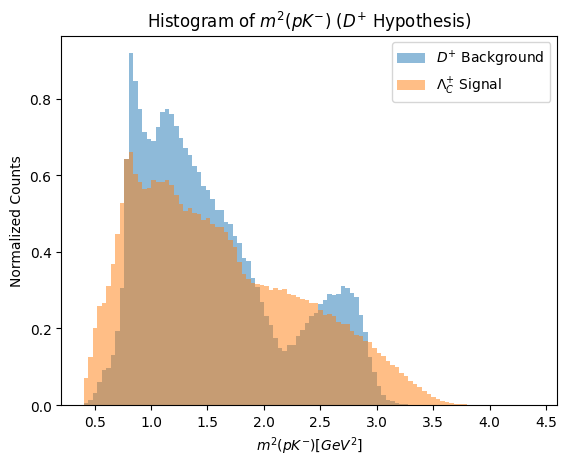

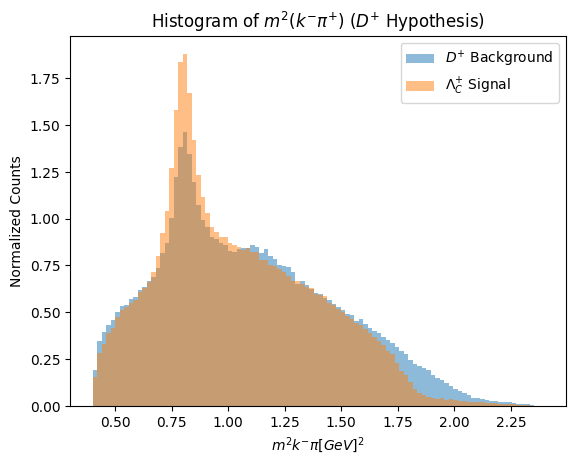

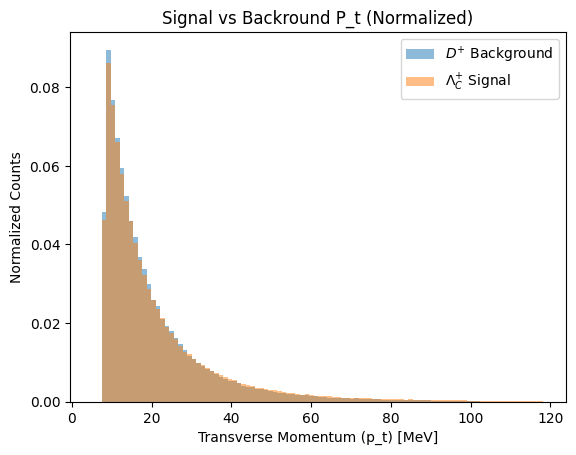

In [14]:
data_list = [(X_train1["inv_mass1"], X_train2["inv_mass1"], "Histogram of $m^2(pK^{-})$ ($D^{+}$ Hypothesis)", "$m^2(pK^{-}) [GeV^{2}]$"),
             (X_train1["inv_mass2"], X_train2["inv_mass2"], "Histogram of $m^2(k^{-}\pi^{+})$ ($D^{+}$ Hypothesis)", "$m^2 k^{-}\pi [GeV]^2$"),
             (X_train1["DMesons_pt"], X_train2["DMesons_pt"], "Signal vs Backround P_t (Normalized)", "Transverse Momentum (p_t) [MeV]")]

def plot_normalized_histograms(data_list, bins):
    for data1, data2, title, xlabel in data_list:
        hist_normalized(data1, data2, bins)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Normalized Counts")
        plt.legend()
        plt.show()

plot_normalized_histograms(data_list, 100)

In [15]:
# counts, bins, _ = plt.hist(X_train1["DMesons_pt"], bins=100)
# counts2, bins2, _ = plt.hist(X_train2["DMesons_pt"], bins=100)
# # Normalize the histogram using the formula
# density = counts / (sum(counts) * np.diff(bins))
# density2 = counts2 / (sum(counts2) * np.diff(bins2))

# # Plot the normalized histogram
# plt.clf()
# plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "$D^{+}$ Background")
# plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
# plt.title("Signal vs Backround P_t (Normalized)")
# plt.xlabel("Transverse Momentum (p_t) [MeV]")
# plt.ylabel("Normalized Counts")
# plt.legend()
# plt.show()

# counts, bins, _ = plt.hist(X_train1["DMesons_fitOutput__Lxy"], bins=100)
# counts2, bins2, _ = plt.hist(X_train2["DMesons_fitOutput__Lxy"], bins=100)
# # Normalize the histogram using the formula
# density = counts / (sum(counts) * np.diff(bins))
# density2 = counts2 / (sum(counts2) * np.diff(bins2))

# # Plot the normalized histogram
# plt.clf()
# plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "$D^{+}$ Background")
# plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
# plt.title("Signal vs Backround Lxy (Normalized)")
# plt.xlabel("Decay Length (L_xy) [mm]")
# plt.ylabel("Normalized Counts")
# plt.legend()
# plt.show()

# counts, bins, _ = plt.hist(X_train1["DMesons_costhetastar"], bins=100)
# counts2, bins2, _ = plt.hist(X_train2["DMesons_costhetastar"], bins=100)
# # Normalize the histogram using the formula
# density = counts / (sum(counts) * np.diff(bins))
# density2 = counts2 / (sum(counts2) * np.diff(bins2))

# # Plot the normalized histogram
# plt.clf()
# plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "$D^{+}$ Background")
# plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
# plt.title("Signal vs Backround cosθ* (Normalized)")
# plt.xlabel("Cosine of Helicity Angle (cosθ*)")
# plt.ylabel("Normalized Counts")
# plt.legend()
# plt.show()

# counts, bins, _ = plt.hist(X_train1["DMesons_fitOutput__ImpactSignificance"], bins=100)
# counts2, bins2, _ = plt.hist(X_train2["DMesons_fitOutput__ImpactSignificance"], bins=100)
# # Normalize the histogram using the formula
# density = counts / (sum(counts) * np.diff(bins))
# density2 = counts2 / (sum(counts2) * np.diff(bins2))

# # Plot the normalized histogram
# plt.clf()
# plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "$D^{+}$ Background")
# plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
# plt.title("Signal vs Backround DMesons ImpactSignificance (Normalized)")
# plt.xlabel("DMesons_fitOutput__ImpactSignificance")
# plt.ylabel("Normalized Counts")
# plt.legend()
# plt.show()

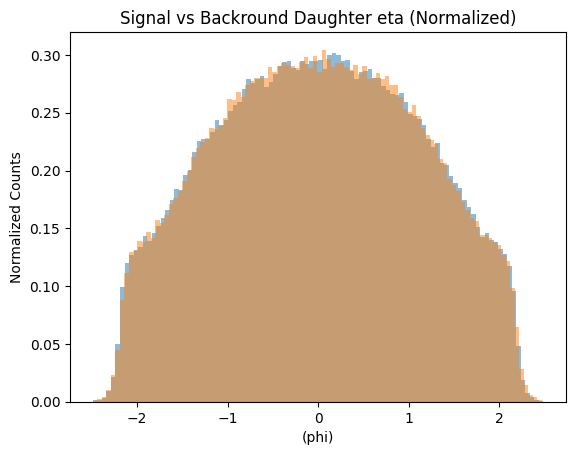

In [7]:
counts, bins, _ = plt.hist(X_train1["daughter_eta2"], bins=100)
counts2, bins2, _ = plt.hist(X_train2["daughter_eta2"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround Daughter eta (Normalized)")
plt.xlabel("(phi)")
plt.ylabel("Normalized Counts")
plt.show()

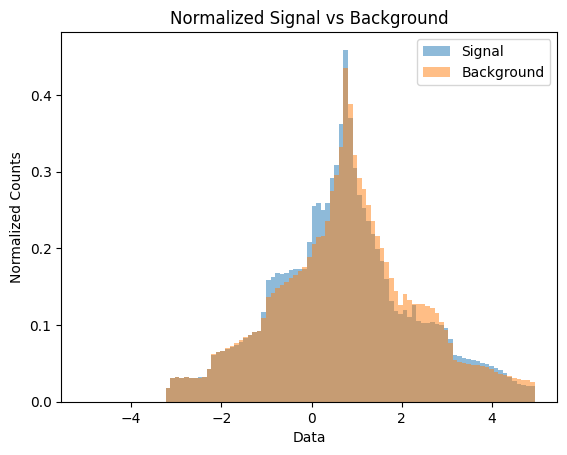

In [99]:
#counts, bins, _ = plt.hist(X_train1, bins=20)
bins = np.linspace(-5, 5, 100)
signal_counts, _ = np.histogram(X_train2, bins=bins, density=True)
background_counts, _ = np.histogram(X_train1, bins=bins, density=True)

# Plot the signal and background histograms on the same plot
plt.bar(bins[:-1], signal_counts, width=np.diff(bins), alpha=0.5, label='Signal')
plt.bar(bins[:-1], background_counts, width=np.diff(bins), alpha=0.5, label='Background')

# Add axis labels and a legend
plt.xlabel('Data')
plt.ylabel('Normalized Counts')
plt.title("Normalized Signal vs Background")
plt.legend()

# Show the plot
plt.show()

In [68]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 128,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 64,
        "activation_2": "relu",
        "dropout_2": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 25,
        "batch_size": 32
    }
)
config = wandb.config

In [69]:
# def get_config(self):
#     return config

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation = config.activation_2)
        self.dropout2 = Dropout(config.dropout_2)
        
        self.dense3 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = self.dropout2(x)
        
        x = self.dense3(x)
        
        return x
    
model = MyModel()
model.build(input_shape=(None, X_train.shape[1]))
model.summary()

def custom_accuracy(y_true, y_pred): 
    
    y_pred_binary = tf.cast(tf.round(y_pred), tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    correct_predictions = tf.equal(y_true, y_pred_binary)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    return accuracy

Model: "my_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            multiple                  2304      
                                                                 
 dropout_11 (Dropout)        multiple                  0         
                                                                 
 dense_15 (Dense)            multiple                  8256      
                                                                 
 dropout_12 (Dropout)        multiple                  0         
                                                                 
 dense_16 (Dense)            multiple                  65        
                                                                 
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
_________________________________________________________________


In [70]:
#Compile
start_time = time.time()

model.compile(optimizer=config.optimizer, loss=config.loss, metrics=[custom_accuracy])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
#Train
with tf.device('/gpu:0'):
    history = model.fit(X_train, y_train, epochs=config.epoch, batch_size=config.batch_size, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

end_time = time.time()
runtime = end_time - start_time
print("Training runtime:", runtime, "seconds")

Epoch 1/25
24991/24996 [============================>.] - ETA: 0s - loss: 0.4209 - custom_accuracy: 0.8139

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230425_212813-lcq170qi/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230425_212813-lcq170qi/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 65s 3ms/step - loss: 0.4209 - custom_accuracy: 0.8139 - val_loss: 0.3693 - val_custom_accuracy: 0.8334
Epoch 2/25
24994/24996 [============================>.] - ETA: 0s - loss: 0.3827 - custom_accuracy: 0.8319

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230425_212813-lcq170qi/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230425_212813-lcq170qi/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 63s 3ms/step - loss: 0.3827 - custom_accuracy: 0.8319 - val_loss: 0.3506 - val_custom_accuracy: 0.8477
Epoch 3/25
24996/24996 [==============================] - 60s 2ms/step - loss: 0.3698 - custom_accuracy: 0.8393 - val_loss: 0.3514 - val_custom_accuracy: 0.8440
Epoch 4/25
24990/24996 [============================>.] - ETA: 0s - loss: 0.3653 - custom_accuracy: 0.8414

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230425_212813-lcq170qi/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230425_212813-lcq170qi/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 61s 2ms/step - loss: 0.3653 - custom_accuracy: 0.8414 - val_loss: 0.3402 - val_custom_accuracy: 0.8531
Epoch 5/25
24992/24996 [============================>.] - ETA: 0s - loss: 0.3621 - custom_accuracy: 0.8435

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230425_212813-lcq170qi/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230425_212813-lcq170qi/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 61s 2ms/step - loss: 0.3621 - custom_accuracy: 0.8435 - val_loss: 0.3280 - val_custom_accuracy: 0.8564
Epoch 6/25
24996/24996 [==============================] - 61s 2ms/step - loss: 0.3584 - custom_accuracy: 0.8449 - val_loss: 0.3315 - val_custom_accuracy: 0.8559
Epoch 7/25
24982/24996 [============================>.] - ETA: 0s - loss: 0.3567 - custom_accuracy: 0.8456

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230425_212813-lcq170qi/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230425_212813-lcq170qi/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 68s 3ms/step - loss: 0.3567 - custom_accuracy: 0.8456 - val_loss: 0.3273 - val_custom_accuracy: 0.8567
Epoch 8/25
24992/24996 [============================>.] - ETA: 0s - loss: 0.3554 - custom_accuracy: 0.8467

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230425_212813-lcq170qi/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230425_212813-lcq170qi/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 68s 3ms/step - loss: 0.3554 - custom_accuracy: 0.8467 - val_loss: 0.3176 - val_custom_accuracy: 0.8606
Epoch 9/25
24996/24996 [==============================] - 60s 2ms/step - loss: 0.3538 - custom_accuracy: 0.8471 - val_loss: 0.3336 - val_custom_accuracy: 0.8531
Epoch 10/25
24996/24996 [==============================] - 61s 2ms/step - loss: 0.3524 - custom_accuracy: 0.8477 - val_loss: 0.3199 - val_custom_accuracy: 0.8597
Epoch 11/25
24996/24996 [==============================] - 62s 2ms/step - loss: 0.3520 - custom_accuracy: 0.8480 - val_loss: 0.3178 - val_custom_accuracy: 0.8598
Epoch 11: early stopping
6249/6249 [==============================] - 8s 1ms/step - loss: 0.3178 - custom_accuracy: 0.8598
Loss: [0.31776025891304016, 0.8598379492759705]
Training runtime: 698.2988255023956 seconds


2023-04-25 21:29:32.527035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-25 21:29:32.539820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-25 21:29:32.682801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-25 21:29:

In [71]:
wandb.finish()

custom_accuracy,▁▅▆▇▇▇█████
epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▄▃▂▂▂▁▁▁▁▁
val_custom_accuracy,▁▅▄▆▇▇▇█▆██
val_loss,█▅▆▄▂▃▂▁▃▁▁
best_epoch,7
best_val_loss,0.3176
custom_accuracy,0.84805
epoch,10
loss,0.35196
val_custom_accuracy,0.85984


------------------------------------------ Finished training, now analyze ------------------------------------------

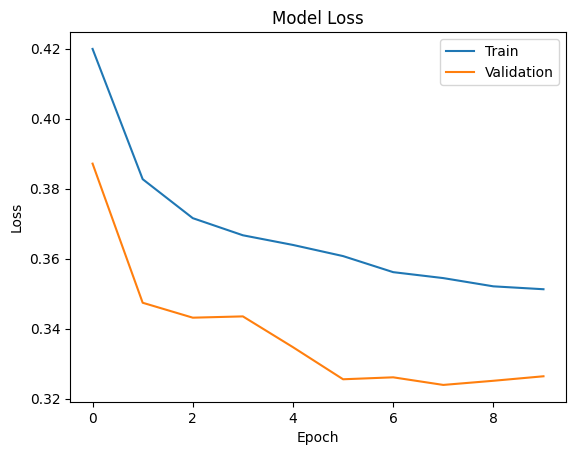

In [49]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [50]:
predictions_both = model.predict(X_test)
predictions_both[:10]

6249/6249 [==============================] - 6s 912us/step


array([[0.7421084 ],
       [0.7309257 ],
       [0.16708013],
       [0.79289716],
       [0.782726  ],
       [0.64194655],
       [0.6113049 ],
       [0.47912112],
       [0.65713793],
       [0.6051733 ]], dtype=float32)

In [ ]:
predictions_both1 = model.predict(X_test)
predictions_both1[:10]

6249/6249 [==============================] - 5s 779us/step


array([[0.7421084 ],
       [0.7309257 ],
       [0.16708013],
       [0.79289716],
       [0.782726  ],
       [0.64194655],
       [0.6113049 ],
       [0.47912112],
       [0.65713793],
       [0.6051733 ]], dtype=float32)

In [ ]:
predictions_background = model.predict(X_test1)
predictions_background[:10]

2535/2535 [==============================] - 2s 816us/step


array([[2.6594493e-01],
       [2.0675162e-04],
       [7.5755017e-03],
       [1.6714209e-01],
       [3.7210968e-03],
       [6.7586899e-02],
       [8.4946314e-03],
       [5.6775540e-01],
       [5.4929817e-01],
       [2.4420813e-01]], dtype=float32)

In [ ]:
predictions_signal = model.predict(X_test2)
predictions_signal[:10]

3714/3714 [==============================] - 3s 831us/step


array([[0.70610845],
       [0.92734313],
       [0.91753334],
       [0.8454196 ],
       [0.1590833 ],
       [0.91406155],
       [0.34259126],
       [0.7213954 ],
       [0.7218171 ],
       [0.9999894 ]], dtype=float32)

In [ ]:
#predict accuract given y_test and predictions from model
def pred_accuracy(y_test, predictions):
    D_count, Lambda_count = 0, 0

    predictions_list = []
    for pred in predictions:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
            Lambda_count+=1
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            D_count+=1
            
    accuracy = np.mean(predictions_list == y_test)
    return accuracy

accuracy_both = pred_accuracy(y_test, list(predictions_both))
accuracy_background = pred_accuracy(y_test1, list(predictions_background))
accuracy_signal = pred_accuracy(y_test2, list(predictions_signal))

print("Accuracy for Both: {:.2%}".format(accuracy_both))
print("Accuracy for Only Background: {:.2%}".format(accuracy_background))
print("Accuracy for Only Signal: {:.2%}".format(accuracy_signal))

Accuracy for Both: 85.65%
Accuracy for Only Background: 71.01%
Accuracy for Only Signal: 95.40%


In [13]:
y_test

NameError: name 'y_test' is not defined

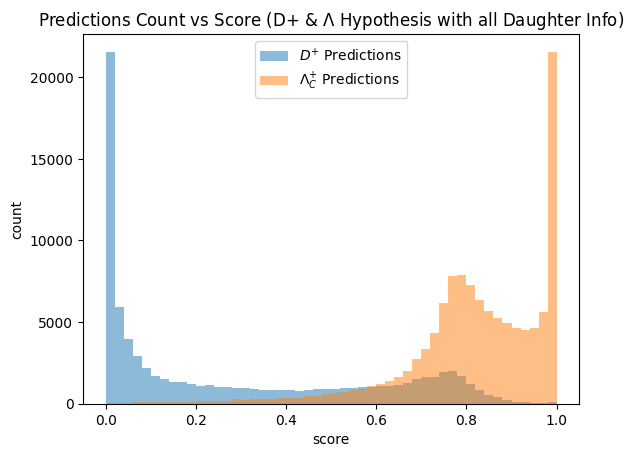

In [ ]:
hist = plt.hist(predictions_background, bins = 50, label = "$D^{+}$ Predictions", alpha=0.5)
hist2 = plt.hist(predictions_signal, bins = 50, label = "$\Lambda_C^{+}$ Predictions", alpha=0.5)
plt.xlabel("score")
plt.ylabel("count")
plt.title("Predictions Count vs Score (D+ & $\Lambda$ Hypothesis with all Daughter Info)")
plt.legend()
plt.show()

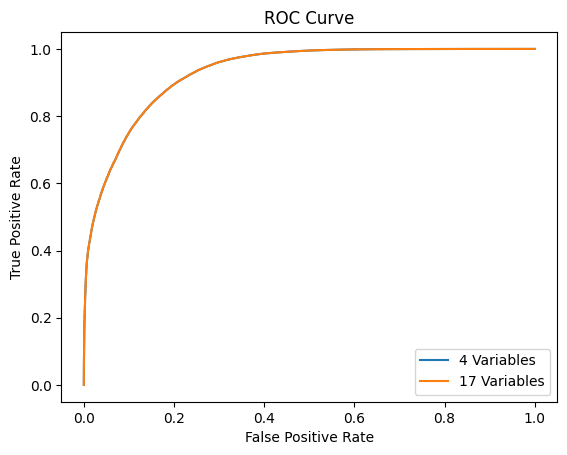

In [ ]:
# Get true labels and predicted probabilities
y_true = list(y_test)
y_pred = predictions_both
y_pred1 = predictions_both1

# Calculate TPR and FPR for different threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
fpr1, tpr1, thresholds1 = roc_curve(y_true, y_pred1)

# Plot ROC curve
plt.plot(fpr, tpr, label = "4 Variables")
plt.plot(fpr1, tpr1, label = "17 Variables")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()